In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']

'0'

In [2]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import time
import math

from datetime import datetime
import os
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,7)
%matplotlib inline

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.examples.tutorials.mnist import input_data

#Data parameters
num_inputs = 28
num_classes = 10
num_steps=28

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
Xtrain = mnist.train.images  # Returns np.array
Xtrain = Xtrain.reshape((-1, num_steps, num_inputs))
ytrain = np.asarray(mnist.train.labels, dtype=np.int32)
Xtest = mnist.test.images  # Returns np.array
Xtest = Xtest.reshape([-1, num_steps, num_inputs])
ytest = np.asarray(mnist.test.labels, dtype=np.int32)

tf.logging.set_verbosity(old_v)

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
print(Xtrain.shape)
print(ytrain.shape)
print(Xtest.shape)
print(ytest.shape)

(55000, 28, 28)
(55000, 10)
(10000, 28, 28)
(10000, 10)


In [5]:
def draw_digits(digits, labels, n_rows=3):
    n = len(digits)
    n_cols = int(n / n_rows)
    for i in range(0, n):
        plt.subplot(n_rows, n_cols, i+1)
        img = digits[i].reshape(28,28)
        label = labels[i].argmax()
        plt.imshow(img, cmap='gray', interpolation='none')
        plt.title(label, fontsize=12)
        plt.tick_params(axis='both', which='major', labelsize=6)
        plt.subplots_adjust(hspace=0.0, wspace=0.5)

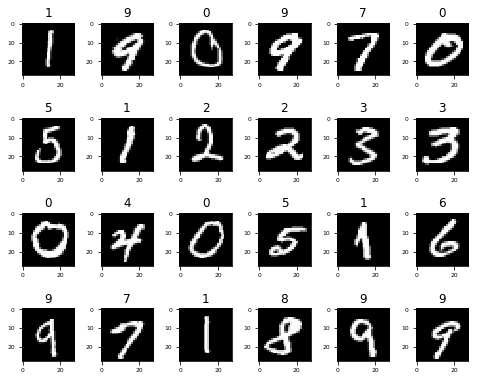

In [6]:
plt.rcParams['figure.figsize'] = (8,7)
digits = mnist.train.images[500:524]
labels = mnist.train.labels[500:524]
draw_digits(digits, labels, n_rows=4)

In [7]:
def log_dir(root_logdir= "", prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

In [8]:
def create_summaries(loss, accuracy):
    tf.summary.scalar("loss", loss)
    tf.summary.scalar("accuracy", accuracy)
    tf.summary.histogram("histogram_loss", loss)
    summary_op = tf.summary.merge_all()
    return summary_op

In [9]:
def LSTM(X, y, keep_prob, num_layers, num_neurons, learning_rate, seed = 42, initializer=None):
    num_inputs = X.get_shape()[2] #28
    num_classes = y.get_shape()[1] #10
    num_steps=X.get_shape()[1] #28
    with tf.name_scope("LSTM"):
        with tf.name_scope("Model"):
            if initializer is None:
                initializer = tf.random_uniform_initializer(minval = -0.1, maxval = 0.1, seed=seed)
            lstm_cells = [tf.contrib.rnn.LSTMCell(num_units=num_neurons, forget_bias=1.0, initializer=initializer, state_is_tuple=True) for layer in range(num_layers)]
            lstm_cells_drop = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob) for cell in lstm_cells]
            multi_layer_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells_drop, state_is_tuple=True)
            outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, time_major = False, dtype=tf.float32)#[Batch_size, time_steps, num_neurons]
        with tf.name_scope('Dense'):
            logits =  tf.layers.dense(inputs = states[-1].h, units = num_classes, name="logits") #[Batch_size, num_classes]
        with tf.name_scope('Predictions'):
            predictions = tf.nn.softmax(logits, name="predictions")  #[Batch_size, num_classes]
        with tf.name_scope('Accuracy'):
            correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        with tf.name_scope('Loss'):
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))
        with tf.name_scope('Train'):
            trainer= tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
        with tf.name_scope("summaries"):
            summary_op = create_summaries(loss, accuracy)
        with tf.name_scope("Saver"):
            saver = tf.train.Saver(max_to_keep=1000000) 
    return predictions, accuracy, loss, trainer, summary_op, saver, lstm_cells

In [10]:
#Network parameters
num_layers = 1
num_neurons = 128
learning_rate = 0.0001

logdir = log_dir("tf_logs", "logreg")

X = tf.placeholder(tf.float32, [None, num_steps, num_inputs], name='input_placeholder')
y = tf.placeholder(tf.float32, [None, num_classes], name='labels_placeholder')
keep_prob = tf.placeholder_with_default(1.0, shape=(), name ="keep_prop")

predictions, accuracy, loss, trainer, summary_op, saver, lstm_cells = LSTM(X, y, keep_prob, num_layers, num_neurons, learning_rate)

train_writer = tf.summary.FileWriter(logdir + '/train', tf.get_default_graph())
validation_writer = tf.summary.FileWriter(logdir + '/val', tf.get_default_graph())

In [11]:
batch_size = 128
num_epochs = 10
train_keep_prob = 0.5
display_step = 1

checkpoint_path = logdir + "my_deep_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = logdir + "final/my_deep_model"

best_loss = np.infty
epochs_without_progress = 0
max_epochs_without_progress = 5

loss_list = []
acc_list = []

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 1
        tf.global_variables_initializer().run()
        print("Initialized")
        
    for epoch in range(start_epoch, num_epochs+1):
        batchNum = mnist.train.num_examples // batch_size
        for batch in range(batchNum):
            xBatch, yBatch = mnist.train.next_batch(batch_size)
            xBatch = xBatch.reshape((batch_size, num_steps, num_inputs))
            _, miniBatchCost = sess.run([trainer, loss], feed_dict={X: xBatch, y: yBatch, keep_prob:train_keep_prob})
        accuracy_train, loss_train, summary_train = sess.run([accuracy, loss, summary_op], feed_dict={X: Xtrain, y: ytrain, keep_prob:train_keep_prob})
        accuracy_val, loss_val, summary_val = sess.run([accuracy, loss, summary_op], feed_dict={X: Xtest, y: ytest, keep_prob:1.0})
        loss_list.append((loss_train, loss_val))
        acc_list.append((accuracy_train, accuracy_val))
    
        train_writer.add_summary(summary_train, epoch)
        validation_writer.add_summary(summary_val, epoch)
        
        if epoch % display_step == 0 or epoch == 1:
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch))
            if loss_val < best_loss:
                saver.save(sess, final_model_path)
                best_loss = loss_val
                save_message = "*"
            else:
                epochs_without_progress += 1
                save_message = ""
                if epochs_without_progress > max_epochs_without_progress:
                    print("Early stopping")
                    break
            print("Epoch: {:d} - ".format(epoch), \
                  "Training Loss: {:.5f}, ".format(loss_train), \
                  "Training Accuracy: {:.2f}%, ".format(accuracy_train*100), \
                  "Validation Loss: {:.4f}, ".format(loss_val), \
                  "Validation Accuracy: {:.2f}%".format(accuracy_val*100),\
                   save_message)
    print("Optimization Finished!")
    
    train_writer.flush()
    validation_writer.flush()
    train_writer.close()
    validation_writer.close()

Initialized
Epoch: 1 -  Training Loss: 0.93136,  Training Accuracy: 68.54%,  Validation Loss: 0.7863,  Validation Accuracy: 74.99% *
Epoch: 2 -  Training Loss: 0.58918,  Training Accuracy: 80.86%,  Validation Loss: 0.4312,  Validation Accuracy: 87.47% *
Epoch: 3 -  Training Loss: 0.47031,  Training Accuracy: 84.81%,  Validation Loss: 0.3203,  Validation Accuracy: 90.70% *
Epoch: 4 -  Training Loss: 0.39549,  Training Accuracy: 87.29%,  Validation Loss: 0.2622,  Validation Accuracy: 91.90% *
Epoch: 5 -  Training Loss: 0.36798,  Training Accuracy: 88.25%,  Validation Loss: 0.2287,  Validation Accuracy: 93.02% *
Epoch: 6 -  Training Loss: 0.31550,  Training Accuracy: 90.00%,  Validation Loss: 0.2096,  Validation Accuracy: 93.87% *
Epoch: 7 -  Training Loss: 0.28571,  Training Accuracy: 90.89%,  Validation Loss: 0.1832,  Validation Accuracy: 94.58% *
Epoch: 8 -  Training Loss: 0.26621,  Training Accuracy: 91.58%,  Validation Loss: 0.1654,  Validation Accuracy: 95.11% *
Epoch: 9 -  Training

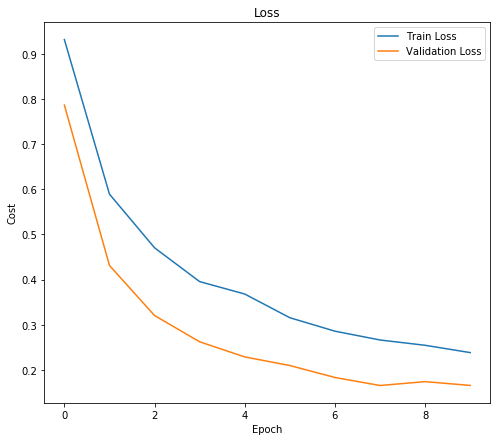

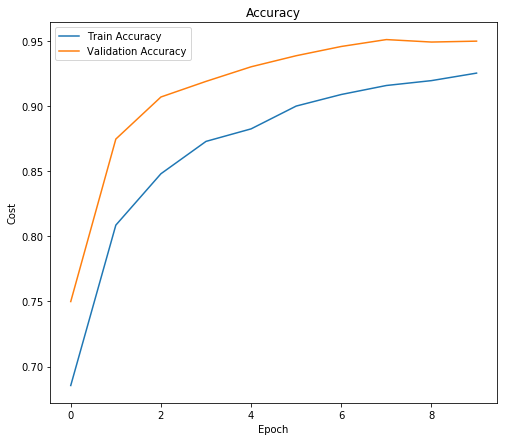

In [12]:
loss_train = []
loss_val = []
for i in range(num_epochs):
    loss_train.append(loss_list[i][0])
    loss_val.append(loss_list[i][1])
    
acc_train = []
acc_val = []
for i in range(num_epochs):
    acc_train.append(acc_list[i][0])
    acc_val.append(acc_list[i][1])

plt.plot(loss_train, label='Train Loss')
plt.plot(loss_val, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title("Loss")
plt.legend()
plt.show()

plt.plot(acc_train, label='Train Accuracy')
plt.plot(acc_val, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title("Accuracy")
plt.legend()
plt.show()

In [14]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('tf_logs/logreg-run-20181023152614/my_deep_model.ckpt.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./tf_logs/logreg-run-20181023152614/'))
    print("Restored Operations from MetaGraph:")
    print(tf.get_default_graph().get_all_collection_keys())
    for v1 in tf.get_default_graph().get_collection(tf.GraphKeys.GLOBAL_VARIABLES):
        print(v1)
    print('----------------------------------------------------')
    for v2 in tf.get_default_graph().get_collection(tf.GraphKeys.TRAINABLE_VARIABLES):
        print(v2)

INFO:tensorflow:Restoring parameters from ./tf_logs/logreg-run-20181023152614/my_deep_model.ckpt
Restored Operations from MetaGraph:
['train_op', 'update_ops', 'summaries', 'variables', 'while_context', 'trainable_variables']
<tf.Variable 'rnn/multi_rnn_cell/cell_0/lstm_cell/kernel:0' shape=(156, 512) dtype=float32_ref>
<tf.Variable 'rnn/multi_rnn_cell/cell_0/lstm_cell/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'logits/kernel:0' shape=(128, 10) dtype=float32_ref>
<tf.Variable 'logits/bias:0' shape=(10,) dtype=float32_ref>
<tf.Variable 'LSTM/Train/beta1_power:0' shape=() dtype=float32_ref>
<tf.Variable 'LSTM/Train/beta2_power:0' shape=() dtype=float32_ref>
<tf.Variable 'rnn/multi_rnn_cell/cell_0/lstm_cell/kernel/Adam:0' shape=(156, 512) dtype=float32_ref>
<tf.Variable 'rnn/multi_rnn_cell/cell_0/lstm_cell/kernel/Adam_1:0' shape=(156, 512) dtype=float32_ref>
<tf.Variable 'rnn/multi_rnn_cell/cell_0/lstm_cell/bias/Adam:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/multi_rnn